In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from BetaFit.model import BetaModel
import statsmodels.api as sm
import math
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import plot_model
import get_data

### 1. 数据探索性分析 ###
* 弄清楚数据大概形态
* 数据的分布形态
（如下两个图形）


### （1）数据形态 ###

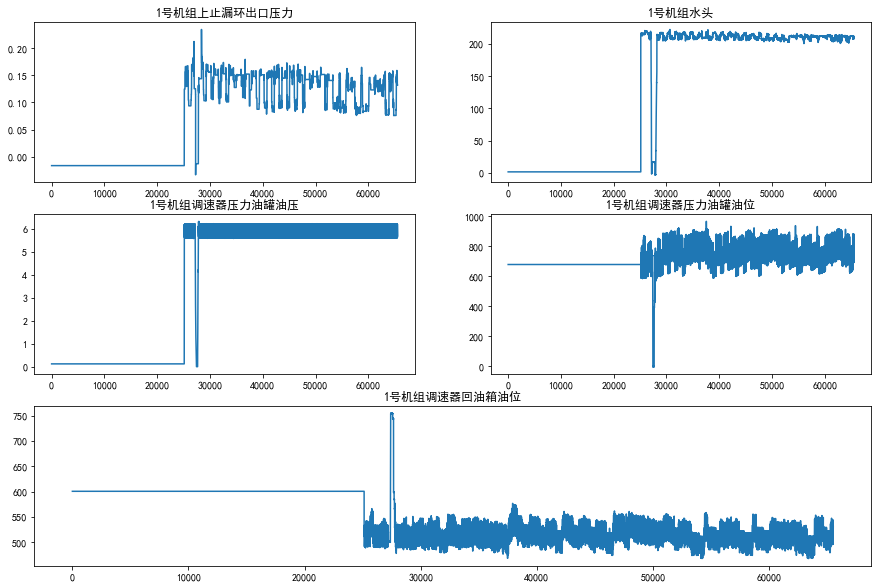

In [5]:
total_data = pd.read_csv("./BetaFit/data.csv")
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (15,10))
xt = range(len(total_data))
plt.subplot(321)
plt.plot(xt, total_data['1号机组上止漏环出口压力'])
plt.title('1号机组上止漏环出口压力')
plt.subplot(322)
plt.plot(xt, total_data['1号机组水头'])
plt.title('1号机组水头')
plt.subplot(323)
plt.plot(xt, total_data['1号机组调速器压力油罐油压'])
plt.title('1号机组调速器压力油罐油压')
plt.subplot(324)
plt.plot(xt, total_data['1号机组调速器压力油罐油位'])
plt.title('1号机组调速器压力油罐油位')
plt.subplot(313)
plt.plot(xt, total_data['1号机组调速器回油箱油位'])
# plt.ylim(40000, 41000)
plt.title('1号机组调速器回油箱油位')
plt.show()

### （2）数据分布形态 ###

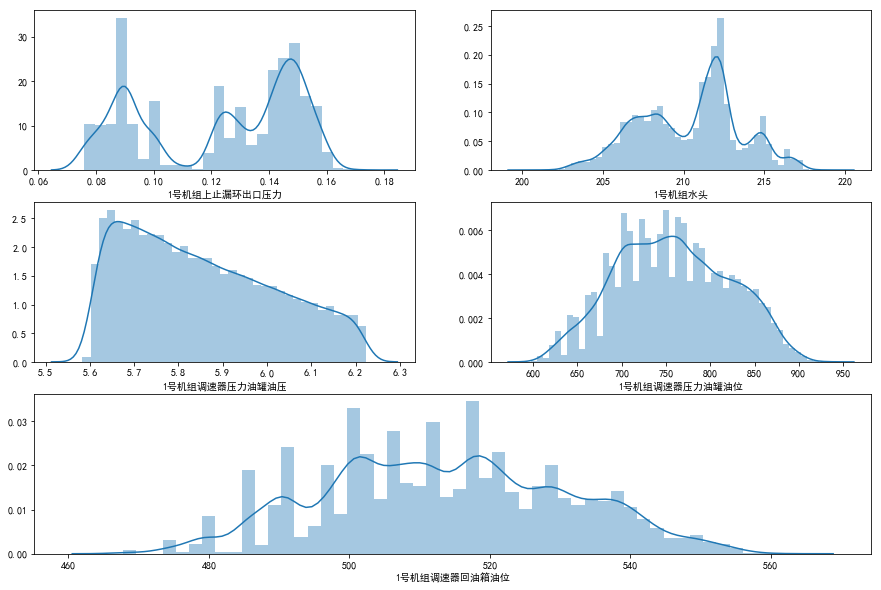

In [6]:
plt.figure(figsize = (15,10))
plt.subplot(321)
sns.distplot(total_data['1号机组上止漏环出口压力'][40000:])
plt.subplot(322)
sns.distplot(total_data['1号机组水头'][40000:])
plt.subplot(323)
sns.distplot(total_data['1号机组调速器压力油罐油压'][40000:])
plt.subplot(324)
sns.distplot(total_data['1号机组调速器压力油罐油位'][40000:])
plt.subplot(313)
sns.distplot(total_data['1号机组调速器回油箱油位'][40000:])
plt.show()

### 2. 模型建立 ###
* 由上可得出结论，数据形态分布不一，使用贝塔分布拟合较好
* 使用原始测点数据拟合贝塔分布

### （1）拟合贝塔分布 ###

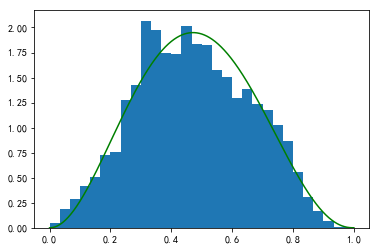

In [26]:
data_one = total_data['1号机组调速器压力油罐油位']
data = total_data['1号机组调速器压力油罐油位'][40000:]
a, b, d1, d2 = BetaModel(data)

### （2）根据分布求出95%的置信区间作为阈值 ###

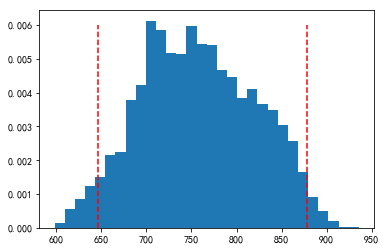

In [27]:
# 2 原始直方图
plt.figure(2)
plt.hist(data, bins=30, normed=True)
plt.vlines(d1, 0, 0.006, colors="r", linestyles="dashed")
plt.vlines(d2, 0, 0.006, colors="r", linestyles="dashed")
plt.show()

### 3. 模型测试 ###
* 原始数据有很多噪音，使用滤波过滤之后测试，会有更高的精度

### （1）对数据进行L1趋势滤波处理 ###

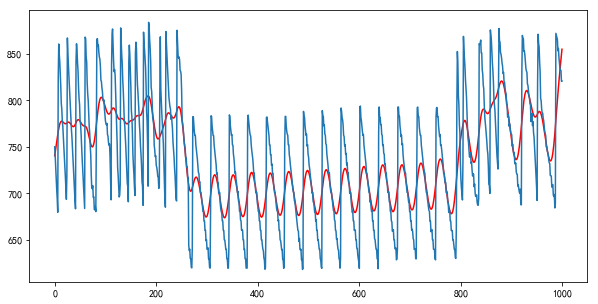

In [28]:
# 滤波
tdata = data[0:1000]
cycle, trend = sm.tsa.filters.hpfilter(tdata, 1600)
cycle1, trend1 = sm.tsa.filters.hpfilter(data_one, 1600)

# 4 原始与滤波后对比
plt.figure(figsize=(10,5))
plt.plot(range(len(tdata)), trend, color='r')
plt.plot(range(len(tdata)), tdata)
plt.show()

### （2）使用滤波过的数据进行阈值测试 ###

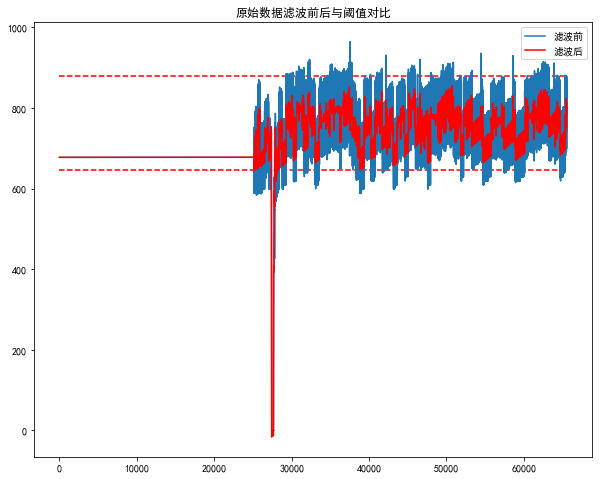

In [29]:
plt.figure(figsize=(10,8))
xline = range(len(data_one))
plt.plot(xline, data_one, label='滤波前')
plt.plot(range(len(trend1)), trend1, color='r', label='滤波后')
plt.hlines(d1, 0, max(xline), colors="r", linestyles="dashed")
plt.hlines(d2, 0, max(xline), colors="r", linestyles="dashed")
plt.legend()
plt.title('原始数据滤波前后与阈值对比')
plt.show()

In [30]:
# 阈值测试
def abnormal(shuju, qujian1, qujian2):
    zc, yc = [], []
    for i in range(len(shuju)):
        if (shuju.values[i] > qujian1 and shuju.values[i] < qujian2):
            zc.append(shuju.values[i])
        else:
            yc.append(shuju.values[i])
    return zc, yc
# 异常识别
zc, yc = abnormal(data, d1, d2)
zc_hp, yc_hp = abnormal(trend, d1, d2)
rate_nhp = (len(yc)/(len(zc)+len(yc)))*100
rate_hp = len(yc_hp)/(len(zc_hp)+len(yc_hp))
print('没有滤波的数据中异常数据所占比率：%f %%' % rate_nhp)
print('滤波之后的数据中异常数据所占比率：%f %%' % rate_hp)

没有滤波的数据中异常数据所占比率：5.443509 %
滤波之后的数据中异常数据所占比率：0.000000 %


### 二、使用Mann-kendall算法进行设备的运行趋势分析 ###

In [31]:
def mk(x):
    s=0
    length=len(x)
    for m in range(0,length-1):
      for n in range(m+1,length):
          if x[n]>x[m]:
              s=s+1
          elif x[n]==x[m]:
              s=s+0
          else:
              s=s-1
    
    vars=length*(length-1)*(2*length+5)/18
    if s>0:
        zc=(s-1)/math.sqrt(vars)
    elif s==0:
        zc=0
    else:
        zc=(s+1)/math.sqrt(vars)
        
    zc1=abs(zc)
    
    ndash=length*(length-1)//2
    slope1=np.zeros(ndash)
    m=0
    for k in range(0,length-1):
        for j  in range(k+1,length):
            slope1[m]=(x[j]-x[k])/(j-k)
            m=m+1
        
    slope=np.median(slope1)
    
    return (slope,zc1)


def CUFK(x):
    sk=0
    length=len(x)
    list = []
    list.append(0.0)
    #print("ufk: 0.0")
    for i in range(2, length):
        for j in range(1, i):
            if x[i]>x[j]:
                sk+=1
            else:
                sk+=0
        esk=float(i*(i-1.0)/4.0)
        varsk=float(i*(i-1.0)*(2.0*i+5.0)/72.0)
        ufk=(sk-esk)/math.sqrt(varsk)
        #print("ufk: ",ufk)
        list.append(ufk)

    return list

def CUBK(x):
    sk=0
    length=len(x)
    list = []
    for i in range(1, length):
        x[i]=x[length-i]

    for i in range(2, length):
        for j in range(1,i):
            if x[i]>x[j]:
                sk+=1
            else:
                sk+=0
        esk=float(i*(i-1.0)/4.0)
        varsk=float(i*(i-1.0)*(2.0*i+5.0)/72.0)
        ubk=0-(sk-esk)/math.sqrt(varsk)
        
        list.append(ubk)
        #print("ubk", ubk)

    return list

def exponential_smoothing(alpha, s):
    s2 = np.zeros(s.shape)
    s2[0] = s[0]
    for i in range(1, len(s2)):
        s2[i] = alpha*s[i]+(1-alpha)*s2[i-1]

    return s2 

def es(list_actual_value):
    alpha = .70
    actual_value_data=np.array(list_actual_value)
    s_single = exponential_smoothing(alpha,actual_value_data)
    s_double = exponential_smoothing(alpha,s_single)
    a_double = 2*s_single-s_double
    b_double = (alpha/(1-alpha))*(s_single-s_double)
    s_pre_double = np.zeros(s_double.shape)
    for i in range(1, len(actual_value_data)):
        s_pre_double[i] = a_double[i-1]+b_double[i-1]

    sp_list = s_pre_double.tolist()
    sp_list.remove(sp_list[0])
    pre_next = a_double[-1]+b_double[-1]*1
    pre_next_two = a_double[-1]+b_double[-1]*2
    sp_list.append(pre_next)
    sp_list.append(pre_next_two)

    return sp_list

def LoadCSVData(path):
    list=[]
    data = pd.read_csv(path)
    for index,row in data.iterrows():
        if index >= 0 and index < 30:
            #print(row['1'])
            list.append(row['1'])

    return list

def WriteCSVData(list, path):
    data = pd.DataFrame(list)
    data.to_csv(path,index=False,sep=',')

def show_data(list_actual_value, sp_list):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(list_actual_value, color='blue', label="actual value")
    plt.plot(sp_list,color='red',label="predictive value")    
    # plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=[0.3, 1])
    plt.title('Projects')
    plt.ylabel('number')
    plt.show()
    
    list_data=LoadCSVData('./sens_mann-kendall/data/show_data.csv')

(slope,zc1)=mk(list_data)
list_ufk=CUFK(list_data)
list_ubk=CUBK(list_data)

print("斜率: ", slope)
print("统计检验量: ", zc1)

斜率:  -0.00026035291666663224
统计检验量:  0.49954886809804416


斜率和统计量主要用于检验序列的趋势
* 斜率值表示序列呈现的趋势，小于0为下降趋势，大于0为上升趋势
* 统计检验值Z，用于进行显著性检验

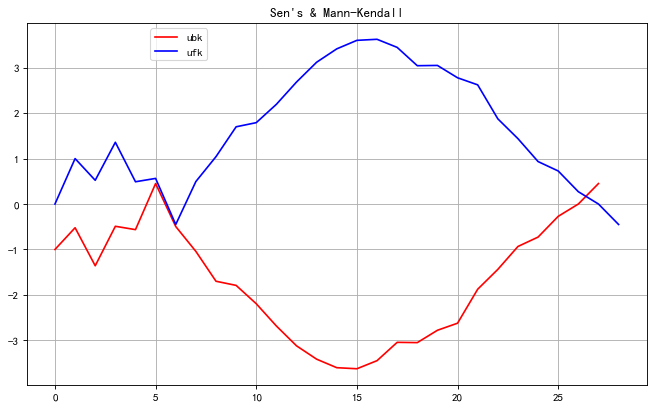

In [32]:


plt.figure(figsize=(10, 6), dpi=80)
plt.plot(list_ubk,'r', label='ubk')
plt.plot(list_ufk,'b',label='ufk')
plt.legend(bbox_to_anchor=[0.3, 1])
plt.title("Sen's & Mann-Kendall")
# plt.legend(loc='lower right')
plt.grid()  
plt.show()

* 这是计算结果的输出图，图中UFK和UBK用于检验序列的突变点，当UFK和UBK两条曲线出现焦点，且交点在临界线之间，那么交点对应的时刻便是突变开始的时刻

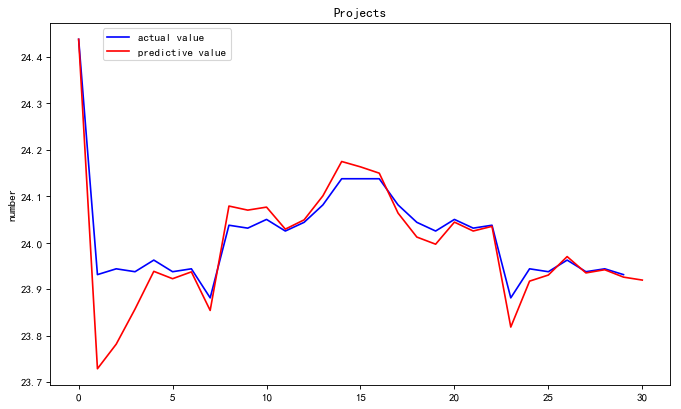

In [33]:
sp_list = es(list_data)
# WriteCSVData(sp_list, "projects/AiPlatform/sens_mann-kendall/data/data_sp.csv")
show_data(list_data, sp_list)

* 这是最后得到的趋势预测图，图中蓝色实线表示真是测点值，红色表示预测值，最后红色多出来的一段是未来下一个单位时间的预测值

### 三、根据设备历史状态数据建模进行设备健康状态评级 ##

In [35]:
num_class=2 #分类数量
epochs=60 #遍历次数
batch_size=128 #批大小

#获取数据集 并且分组
(x_train, y_train), (x_test, y_test)=get_data.load_data(file_path='./keras/xiaowan/data/train_data.csv',y_name='6')
#转换DataFrame对象为张量数组
x_train=x_train.values
y_train=y_train.values
x_test=x_test.values
y_test=y_test.values

# print(x_train.shape)
y_train=keras.utils.to_categorical(y_train,2)
y_test=keras.utils.to_categorical(y_test,2)

# 定义神经网络模型的层结构
model=Sequential()
model.add(Dense(5,input_shape=(5,),activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_class,activation='softmax'))

# 指定优化器 损失
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 训练模型
history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.25)
# print(history.history.keys())
# 保存模型
# model.save('./model/model.h5')

# 评估模型
acc=model.evaluate(x_test,y_test,verbose=0)
print(acc)


Train on 1050 samples, validate on 350 samples
Epoch 1/60
1050/1050 [==============================] - 1s 683us/step - loss: 0.9012 - acc: 0.4981 - val_loss: 0.8396 - val_acc: 0.4971
Epoch 2/60
1050/1050 [==============================] - 0s 41us/step - loss: 0.8685 - acc: 0.4686 - val_loss: 0.8112 - val_acc: 0.4914
Epoch 3/60
1050/1050 [==============================] - 0s 40us/step - loss: 0.8378 - acc: 0.4562 - val_loss: 0.7850 - val_acc: 0.4800
Epoch 4/60
1050/1050 [==============================] - 0s 40us/step - loss: 0.8095 - acc: 0.4476 - val_loss: 0.7618 - val_acc: 0.4686
Epoch 5/60
1050/1050 [==============================] - 0s 39us/step - loss: 0.7846 - acc: 0.4400 - val_loss: 0.7408 - val_acc: 0.4657
Epoch 6/60
1050/1050 [==============================] - 0s 41us/step - loss: 0.7620 - acc: 0.4333 - val_loss: 0.7250 - val_acc: 0.4600
Epoch 7/60
1050/1050 [==============================] - 0s 41us/step - loss: 0.7474 - acc: 0.4181 - val_loss: 0.7138 - val_acc: 0.5200
Epoch 8

[0.2542183889945348, 0.9683333333333334]


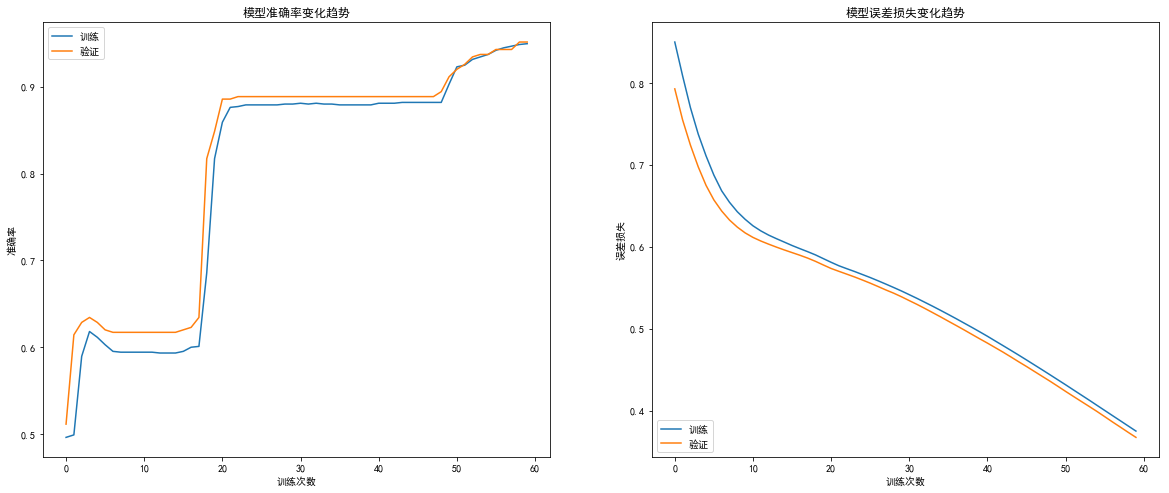

In [22]:
# 解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20,8))
# plt.plot(history.history['epoch'],history.history['loss'])
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('模型准确率变化趋势')
plt.ylabel('准确率')
plt.xlabel('训练次数')
plt.legend(['训练', '验证'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('模型误差损失变化趋势')
plt.ylabel('误差损失')
plt.xlabel('训练次数')
plt.legend(['训练', '验证'], loc='lower left')

plt.show()